# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Understand batching for a recurrent neural network, and develop custom Dataset and DataLoaders with collate_fn to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1omISu9ID3OrJrAGYfNZBbGOHPl2ic751?usp=sharing

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [1 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
printed_ham = 0
printed_spam = 0
for line in open('SMSSpamCollection'):
    label = line.split("\t")[0]

    if label == "ham" and printed_ham == 0:
      print("Non spam message => ham")
      print(line)
      printed_ham += 1
    if label == "spam" and printed_spam == 0:
      print("Spam message => spam")
      print(line)
      printed_spam += 1
    if printed_ham == 1 and printed_spam == 1:
      break


Non spam message => ham
ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Spam message => spam
spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
count_spam = 0
count_ham = 0
other = 0
for line in open('SMSSpamCollection'):
    label = line.split("\t")[0]
    if label == "spam":
      count_spam += 1
    elif label == "ham":
      count_ham += 1
    else:
      other += 1
print(f"Number of spam messages: {count_spam}")
print(f"Number of non-spam messages: {count_ham}")
print(f"Other: {other}")

Number of spam messages: 747
Number of non-spam messages: 4827
Other: 0


### Part (c) [4 pt]

load and parse the data into two lists: sequences and labels. Create character-level stoi and itos dictionaries. Reserve the index 0 for padding. Convert the sequences to list of character ids using stoi dictionary and convert the labels to a list of 0s and 1s by assinging class "ham" to 0 and class "spam" to 1.

In [ ]:
sequences = []
labels = []

#Load and Parse data
for line in open('SMSSpamCollection'):
    label, message = line.split("\t")
    sequences.append(message)
    labels.append(0 if label == "ham" else 1)

#Create stoi and itos dictionaries
index = 1
stoi = {"padding":0}
itos = {0:"padding"}
for message in sequences:
    for c in message:
        if c not in stoi:
            stoi[c] = index
            itos[index] = c
            index += 1

#Convert sequences to list of character ids
char_id_sequences = []
for message in sequences:
    char_ids = []
    for c in message:
        char_ids.append(stoi[c])
    char_id_sequences.append(char_ids)



### Part (d) [4 pt]

Use train_test_split function from sklearn (https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.train_test_split.html) to split the data indices into `train`, `valid`, and `test`. Use a 60-20-20 split.

You saw in part (b) that there are many more non-spam messages than spam messages. This **imbalance** in our training data will be problematic for training. We can fix this disparity by duplicating spam messages in the training set, so that the training set is roughly balanced.

In [ ]:
from sklearn.model_selection import train_test_split

train_index, temp_index = train_test_split(np.arange(len(labels)), test_size=0.4, random_state=42)
val_index, test_index = train_test_split(temp_index, test_size=0.5, random_state=0)

x = char_id_sequences
y = labels

train_x = [x[idx] for idx in train_index]
train_y = [y[idx] for idx in train_index]
val_x = [x[idx] for idx in val_index]
val_y = [y[idx] for idx in val_index]
test_x = [x[idx] for idx in test_index]
test_y = [y[idx] for idx in test_index]

#Balance the train classes
train_spam = []
for idx, item in enumerate(train_x):
    if train_y[idx] == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train_x = train_x + train_spam * 6
train_y = train_y + [1] * (len(train_spam) * 6)

### Part (e) [4 pt]

Since each sequence has a different length, we cannot use the default DataLoader. We need to change the DataLoader such that it can pad differnt sequence sizes within the batch. To do this, we need to introduce a **collate_fn** to the DataLoader such that it uses **pad_sequence** function (https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html) to pad the sequences within the batch to the same size.

We also need a custom Dataset class to return a pair of sequence and label for each example. Complete the code below to address these.

Hint:
- https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
- https://plainenglish.io/blog/understanding-collate-fn-in-pytorch-f9d1742647d3

In [ ]:
class MyDataset(Dataset):
    def __init__(self, sequences, labels):
        self.labels = labels
        self.sequences = sequences
    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X = torch.tensor(self.sequences[idx], dtype=torch.int64)
        y = torch.tensor(self.labels[idx], dtype=torch.float32)

        return X, y

def collate_sequences(batch):
    inputs = [b[0] for b in batch]
    labels = [b[1] for b in batch]

    inputs = pad_sequence(inputs, batch_first=True)
    labels = torch.tensor(labels)
    return inputs, labels

train_loader = DataLoader(dataset=MyDataset(train_x, train_y), batch_size=32, shuffle=True, collate_fn=collate_sequences)
val_loader = DataLoader(dataset=MyDataset(val_x, val_y), batch_size=32, shuffle=False, collate_fn=collate_sequences)
test_loader = DataLoader(dataset=MyDataset(test_x, test_y), batch_size=32, shuffle=False, collate_fn=collate_sequences)

### Part (f) [1 pt]

Take a look at 10 batches in `train_loader`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
i = 0
pad_token = 0
for batch in train_loader:
    data, label = batch

    pad_count = (data == pad_token).sum().item()
    print(f"Maximum Length of input sequence in batch {i}: {len(data[0])} & {pad_count} pad tokens are used")
    i += 1
    if i == 10:
      break


Maximum Length of input sequence in batch 0: 181 & 2419 pad tokens are used
Maximum Length of input sequence in batch 1: 161 & 1635 pad tokens are used
Maximum Length of input sequence in batch 2: 224 & 3991 pad tokens are used
Maximum Length of input sequence in batch 3: 224 & 3618 pad tokens are used
Maximum Length of input sequence in batch 4: 243 & 4364 pad tokens are used
Maximum Length of input sequence in batch 5: 198 & 2517 pad tokens are used
Maximum Length of input sequence in batch 6: 333 & 6878 pad tokens are used
Maximum Length of input sequence in batch 7: 203 & 3013 pad tokens are used
Maximum Length of input sequence in batch 8: 176 & 2303 pad tokens are used
Maximum Length of input sequence in batch 9: 298 & 5939 pad tokens are used


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing.
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x].long()) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]])


In [ ]:
class Simple_RNN(nn.Module):
    def __init__(self, name, hidden_size):
        super(Simple_RNN, self).__init__()
        self.name = name
        self.embedding = nn.Embedding(len(stoi), 32, padding_idx=0)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(118, hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self,x, embed = False):
        if embed == True:
          x = self.embedding(x)
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, __ = self.rnn(x,h0)
        return (self.fc(out[:,-1,:])).squeeze()

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).

In [ ]:
def get_accuracy(model, data, embed):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    total_num = 0
    total_err = 0
    ident = torch.eye(len(stoi))
    for message, label in data:
        if embed == False:
          message = ident[message]
        pred = model(message, embed)
        pred_prob = F.sigmoid(pred)
        prediction = pred_prob > 0.5
        corr = prediction != label
        total_err += int(corr.sum())
        total_num += len(label)
    return 1-(total_err/total_num)

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values
    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path
def evaluate_loss(model, data, criterion, embed):
    ident = torch.eye(len(stoi))
    total_loss = 0
    num_batches = 0
    for message, label in data:
        if embed == False:
          message = ident[message]
        y_pred = model(message, embed)
        loss = criterion(y_pred, label)
        total_loss += loss.item()
        num_batches += 1
    return total_loss/num_batches
def plot_loss(train_loss_record, val_loss_record, train_accuracy_record, val_accuracy_record):

    plt.figure(figsize=(10, 6))
    plt.plot(train_loss_record, label='Training Loss')
    plt.plot(val_loss_record, label='Validation Loss', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Each Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(train_accuracy_record, label='Training Accuracy')
    plt.plot(val_accuracy_record, label='Validation Accuracy', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Each Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()
def train(model, n_epochs, learning_rate, print_loss = 1, embed = False):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    ident = torch.eye(len(stoi))

    train_loss_record = []
    val_loss_record = []
    train_accuracy_record = []
    val_accuracy_record = []

    for epoch in range(n_epochs):
        train_loss = 0
        num_batches = 0
        for message, label in train_loader:
            if embed == False:
              message = ident[message]
            #print(message.shape)
            y_pred = model(message, embed)
            loss = criterion(y_pred, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            num_batches += 1
        #Train loss, Val loss
        avg_loss = train_loss/num_batches
        train_loss_record.append(avg_loss)
        val_loss = evaluate_loss(model, val_loader, nn.BCEWithLogitsLoss(), embed)
        val_loss_record.append(val_loss)

        #Train Accuracy, Val Accuracy
        train_accuracy = get_accuracy(model,train_loader,embed)
        train_accuracy_record.append(train_accuracy)
        val_accuracy = get_accuracy(model, val_loader, embed)
        val_accuracy_record.append(val_accuracy)

        #Print loss, accuracy every epoch
        if print_loss == 1:
            print(f"Epoch {epoch}: Train Loss = {avg_loss} / Train Accuracy = {train_accuracy} \
            / Val Loss = {val_loss} / Val Accuracy = {val_accuracy}")
        #Save model every epoch
        model_path = get_model_name(model.name, 32, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)
    return train_loss_record, val_loss_record, train_accuracy_record, val_accuracy_record

In [ ]:
model = Simple_RNN("simple", 64)
train_loss_record, val_loss_record, train_accuracy_record, val_accuracy_record = train(model, 10, 0.0001)

Epoch 0: Train Loss = 0.6921889945943519 / Train Accuracy = 0.5192499170262197 / Val Loss = 0.7175754853657313 / Val Accuracy = 0.13632286995515697
Epoch 1: Train Loss = 0.691761488321597 / Train Accuracy = 0.5192499170262197 / Val Loss = 0.7272795762334551 / Val Accuracy = 0.13632286995515697
Epoch 2: Train Loss = 0.6892279619893069 / Train Accuracy = 0.6038831729173582 / Val Loss = 0.6817774040358408 / Val Accuracy = 0.8582959641255605
Epoch 3: Train Loss = 0.6947238508355681 / Train Accuracy = 0.7047792897444407 / Val Loss = 0.6273493920053754 / Val Accuracy = 0.8331838565022421
Epoch 4: Train Loss = 0.6528653261207399 / Train Accuracy = 0.5816461998008629 / Val Loss = 0.7175961213452475 / Val Accuracy = 0.4053811659192825
Epoch 5: Train Loss = 0.6450046334001753 / Train Accuracy = 0.7243611018918021 / Val Loss = 0.5326607831886836 / Val Accuracy = 0.8269058295964126
Epoch 6: Train Loss = 0.6343478923121457 / Train Accuracy = 0.7346498506471955 / Val Loss = 0.5330835027354104 / Val 

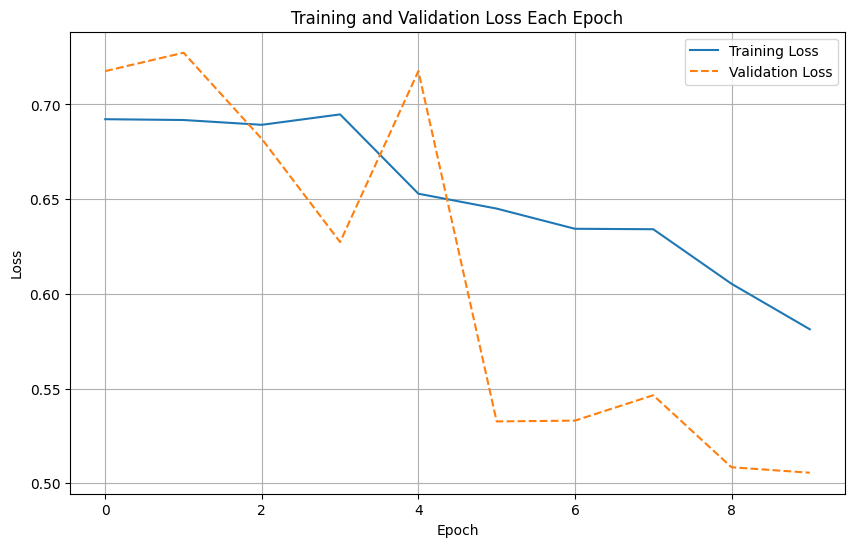

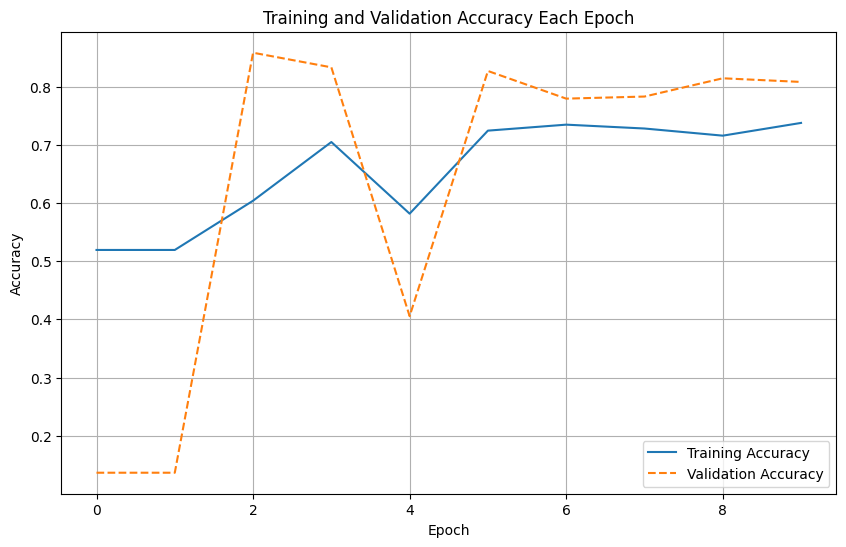

In [ ]:
plot_loss(train_loss_record, val_loss_record, train_accuracy_record, val_accuracy_record)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

In [ ]:
#First, I want to try using nn.Embedding, using one hot encoding might make the data too sparse
#Which can contains lots of useless values.


model = Simple_RNN("model1", 32)
model.rnn = nn.RNN(32, 32, batch_first = True)

train_loss_record, val_loss_record, train_accuracy_record, val_accuracy_record = train(model, 10, learning_rate=0.0001,
                                                                                       print_loss = 1, embed = True)

Epoch 0: Train Loss = 0.6933139565760497 / Train Accuracy = 0.5111184865582477 / Val Loss = 0.7009324499538967 / Val Accuracy = 0.1354260089686099
Epoch 1: Train Loss = 0.691570899473927 / Train Accuracy = 0.5204115499502158 / Val Loss = 0.7155927811350141 / Val Accuracy = 0.1354260089686099
Epoch 2: Train Loss = 0.6904568646950696 / Train Accuracy = 0.5199137072685032 / Val Loss = 0.7155080199241638 / Val Accuracy = 0.13721973094170403
Epoch 3: Train Loss = 0.6897295041689797 / Train Accuracy = 0.520079654829074 / Val Loss = 0.7149794220924377 / Val Accuracy = 0.13991031390134534
Epoch 4: Train Loss = 0.6864451813319373 / Train Accuracy = 0.5726850315300365 / Val Loss = 0.6795927371297564 / Val Accuracy = 0.8600896860986547
Epoch 5: Train Loss = 0.6503350116588451 / Train Accuracy = 0.7227016262860936 / Val Loss = 0.6140908019883292 / Val Accuracy = 0.6878923766816143
Epoch 6: Train Loss = 0.6051632350399381 / Train Accuracy = 0.6520079654829074 / Val Loss = 0.8795894827161517 / Val A

In [ ]:
#The result from model1 has the best Validation Accuracy of 0.86. I want to try adding
#concatenation of the max-pooling and average-pooling of the RNN outputs


class Modified_RNN(Simple_RNN):
    def __init__(self, name, hidden_size):
        super(Modified_RNN, self).__init__(name, hidden_size)

    def forward(self,x, embed = False):
        if embed == True:
          x = self.embedding(x)
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, __ = self.rnn(x,h0)
        out = torch.cat([torch.max(out, dim=1)[0],
                        torch.mean(out, dim=1)], dim=1)

        return (self.fc(out)).squeeze()
model = Modified_RNN("model2", 32)
model.rnn = nn.RNN(32, 32, batch_first = True)
model.fc = nn.Linear(64, 1)

train_loss_record, val_loss_record, train_accuracy_record, val_accuracy_record = train(model, 10, learning_rate=0.0001,
                                                                                       print_loss = 1, embed = True)

Epoch 0: Train Loss = 0.6754961600379338 / Train Accuracy = 0.7987056090275473 / Val Loss = 0.6709712777818952 / Val Accuracy = 0.7399103139013453
Epoch 1: Train Loss = 0.5922808714959987 / Train Accuracy = 0.7821108529704613 / Val Loss = 0.5271787992545537 / Val Accuracy = 0.7973094170403587
Epoch 2: Train Loss = 0.49375105597985486 / Train Accuracy = 0.8006969797543976 / Val Loss = 0.43333698681422644 / Val Accuracy = 0.8340807174887892
Epoch 3: Train Loss = 0.4283150048167617 / Train Accuracy = 0.8703949551941587 / Val Loss = 0.3722845562866756 / Val Accuracy = 0.8699551569506727
Epoch 4: Train Loss = 0.3659551701848469 / Train Accuracy = 0.880683703949552 / Val Loss = 0.36470430876527515 / Val Accuracy = 0.8807174887892377
Epoch 5: Train Loss = 0.33916470786881825 / Train Accuracy = 0.8386989711251245 / Val Loss = 0.583747205563954 / Val Accuracy = 0.7659192825112108
Epoch 6: Train Loss = 0.32050657887307427 / Train Accuracy = 0.904248257550614 / Val Loss = 0.30943079250199457 / Va

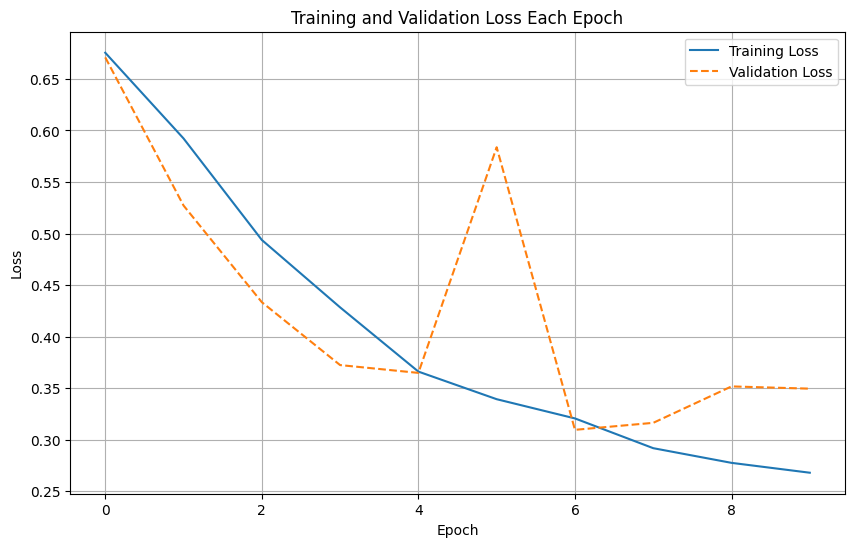

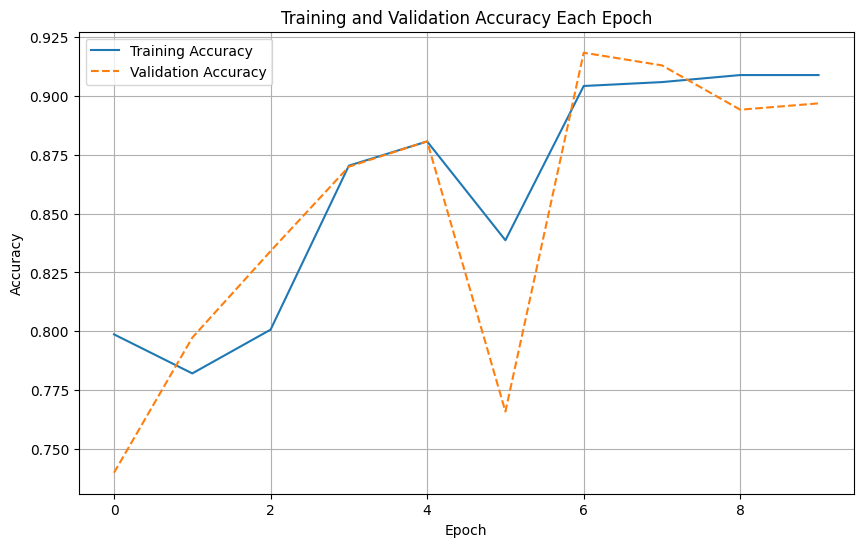

In [ ]:
plot_loss(train_loss_record, val_loss_record, train_accuracy_record, val_accuracy_record)

In [ ]:
#The model2 is able to achieve the best validation accuracy of 0.918. Seen from the training curve, the model hasn't
#passed the point of overfitting and the training time is quite fast, so I will increase n_epochs and train model2 again

model = Modified_RNN("model3", 32)
model.rnn = nn.RNN(32, 32, batch_first = True)
model.fc = nn.Linear(64, 1)

train_loss_record, val_loss_record, train_accuracy_record, val_accuracy_record = train(model, 30, learning_rate=0.0001,
                                                                                       print_loss = 1, embed = True)

Epoch 0: Train Loss = 0.6792731534236323 / Train Accuracy = 0.7597079322933953 / Val Loss = 0.6861069662230356 / Val Accuracy = 0.6295964125560538
Epoch 1: Train Loss = 0.6260507390612647 / Train Accuracy = 0.7983737139064055 / Val Loss = 0.5600335725716182 / Val Accuracy = 0.8
Epoch 2: Train Loss = 0.508285358311638 / Train Accuracy = 0.8006969797543976 / Val Loss = 0.4933810864176069 / Val Accuracy = 0.810762331838565
Epoch 3: Train Loss = 0.46045719646902944 / Train Accuracy = 0.8075008297378028 / Val Loss = 0.44894336206572394 / Val Accuracy = 0.8233183856502242
Epoch 4: Train Loss = 0.4362545213686726 / Train Accuracy = 0.8234317955526054 / Val Loss = 0.4132606821400779 / Val Accuracy = 0.8349775784753364
Epoch 5: Train Loss = 0.46255317622076264 / Train Accuracy = 0.8138068370394955 / Val Loss = 0.3380652487277985 / Val Accuracy = 0.8762331838565023
Epoch 6: Train Loss = 0.4033213324016995 / Train Accuracy = 0.8413541320942582 / Val Loss = 0.3700379124709538 / Val Accuracy = 0.85

In [ ]:
#The model3 is able to achieve the best validation accuracy of 0.97. The result is very impressive, but the
#model still has not overfit. So, I will try to add some complexity from hidden_size hoping it can fit the data better.
model = Modified_RNN("model4", 64)
model.rnn = nn.RNN(32, 64, batch_first = True)
model.fc = nn.Linear(128, 1)

train_loss_record, val_loss_record, train_accuracy_record, val_accuracy_record = train(model, 30, learning_rate=0.0001,
                                                                                       print_loss = 1, embed = True)

Epoch 0: Train Loss = 0.6686537726215585 / Train Accuracy = 0.8821772319946897 / Val Loss = 0.6252358879361833 / Val Accuracy = 0.8762331838565023
Epoch 1: Train Loss = 0.5062303401174999 / Train Accuracy = 0.80501161632924 / Val Loss = 0.5873831152915955 / Val Accuracy = 0.7210762331838565
Epoch 2: Train Loss = 0.39555930090013636 / Train Accuracy = 0.8816793893129771 / Val Loss = 0.3594278744288853 / Val Accuracy = 0.884304932735426
Epoch 3: Train Loss = 0.33849820778483436 / Train Accuracy = 0.8914702953866578 / Val Loss = 0.3093830053295408 / Val Accuracy = 0.9049327354260089
Epoch 4: Train Loss = 0.30368317592711674 / Train Accuracy = 0.8997676734152008 / Val Loss = 0.2611501781003816 / Val Accuracy = 0.9264573991031391
Epoch 5: Train Loss = 0.33860469305956803 / Train Accuracy = 0.9069034185197478 / Val Loss = 0.3475653214114053 / Val Accuracy = 0.8905829596412556
Epoch 6: Train Loss = 0.2726509511549637 / Train Accuracy = 0.916030534351145 / Val Loss = 0.26002303830214907 / Val 

In [ ]:
#Model4 is the best model with validation accuracy of 0.974

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
#Load model
Best_model = Modified_RNN("Best", 64)
Best_model.rnn = nn.RNN(32, 64, batch_first = True)
Best_model.fc = nn.Linear(128, 1)
model_path = get_model_name("model4", batch_size=32, learning_rate=0.0001, epoch =26)
state = torch.load(model_path)
Best_model.load_state_dict(state)

<ipython-input-102-ded29a02a09f>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


<All keys matched successfully>

In [ ]:
#Get the data with negative label
labels = val_loader.dataset.labels
mask = (torch.tensor(labels) == 0)

filtered_indices = torch.nonzero(mask).squeeze()

negative = torch.utils.data.DataLoader(
    dataset=torch.utils.data.Subset(val_loader.dataset, filtered_indices),
    batch_size=32,
    shuffle=False,
    collate_fn=val_loader.collate_fn
)

#Get the data with positive label
mask = (torch.tensor(labels) == 1)

filtered_indices = torch.nonzero(mask).squeeze()

positive = torch.utils.data.DataLoader(
    dataset=torch.utils.data.Subset(val_loader.dataset, filtered_indices),
    batch_size=32,
    shuffle=False,
    collate_fn=val_loader.collate_fn
)

fpr = 1 - get_accuracy(Best_model, negative, True)
fnr = 1 - get_accuracy(Best_model, positive, True)

print(f"False Positive Rate: {fpr}, False Negative Rate: {fnr}")

False Positive Rate: 0.01661474558670817, False Negative Rate: 0.05921052631578949


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

**Answer:** False positive is when the model classifies a message as spam, but actually it is not. Therefore, if the phone discard this message, the user will never get to see the message which might contain important information.

False Negative is when the model classifies a message as non-spam, but actually it is a spam message. This is not impactful because the user did not lose any important information, but they just need to discard the spam message on their own.

In summary, False positive is a lot more impactful than False Negative in this case.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
print(f"Final Test Accuracy: {get_accuracy(Best_model, test_loader, True)*100}%")

Final Test Accuracy: 96.8609865470852%


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
labels = test_loader.dataset.labels
mask = (torch.tensor(labels) == 0)

filtered_indices = torch.nonzero(mask).squeeze()

negative = torch.utils.data.DataLoader(
    dataset=torch.utils.data.Subset(test_loader.dataset, filtered_indices),
    batch_size=32,
    shuffle=False,
    collate_fn=test_loader.collate_fn
)

#Get the data with positive label
mask = (torch.tensor(labels) == 1)

filtered_indices = torch.nonzero(mask).squeeze()

positive = torch.utils.data.DataLoader(
    dataset=torch.utils.data.Subset(test_loader.dataset, filtered_indices),
    batch_size=32,
    shuffle=False,
    collate_fn=test_loader.collate_fn
)

fpr = 1 - get_accuracy(Best_model, negative, True)
fnr = 1 - get_accuracy(Best_model, positive, True)

print(f"False Positive Rate: {fpr}, False Negative Rate: {fnr}")

False Positive Rate: 0.026887280248190315, False Negative Rate: 0.04729729729729726


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "machine learning is sooo cool!"
msg_id = []
for c in msg:
    msg_id.append(stoi[c])
msg_id = torch.tensor([msg_id], dtype=torch.int64)
prob = F.sigmoid(Best_model(msg_id,True))
print(f"Probability = {prob*100}%")

Probability = 34.48308563232422%


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

In [ ]:
#I think detecting spams is quite close to detecting scam calls. Since scam calls have been a big problem up until now,
#I think both detecting spams and scam calls are difficult tasks.

#I will use a simple model that detects if words like "free", "win", "limited time" are in the messages. If those words
#exist, we classify as spam. If not, we classify as non-spam.

In [ ]:
%%shell
jupyter nbconvert --to html /content/Lab5_Spam_Detection_2.ipynb

[NbConvertApp] Converting notebook /content/Lab5_Spam_Detection_2.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 647906 bytes to /content/Lab5_Spam_Detection_2.html
